# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 2


## ⚙️ Import Libraries

In [2]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 0


## ⏳ Load the Data

In [3]:
data = np.load("mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


## Analyze data


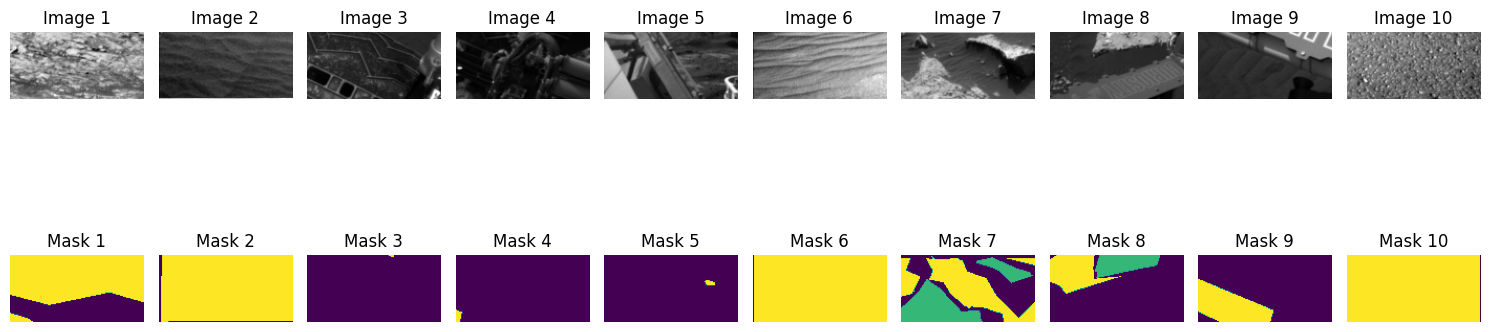

In [4]:
# Visualize the data
# Reshape to 2D for visualization
X_train_images = np.array([x.reshape(64, 128) for x in X_train])
y_train_masks = np.array([y.reshape(64, 128) for y in y_train])

# Plot the first 5 images and their corresponding masks
fig, axes = plt.subplots(2, 10, figsize=(15, 6))
for i in range(10):
    # Input images
    axes[0, i].imshow(X_train_images[i], cmap="gray")
    axes[0, i].set_title(f"Image {i+1}")
    axes[0, i].axis("off")

    # Masks
    axes[1, i].imshow(y_train_masks[i], cmap="viridis")
    axes[1, i].set_title(f"Mask {i+1}")
    axes[1, i].axis("off")
plt.tight_layout()
plt.show()

## Class Imbalance

In [5]:
# Define class labels as a dictionary
class_labels = {
    0: "Background",
    1: "Soil",
    2: "Bedrock",
    3: "Sand",
    4: "Big Rock"
}


Class Distribution in Masks (Filtered Dataset):
Class 0.0 (Background): 5466886 pixels
Class 1.0 (Soil): 7131118 pixels
Class 2.0 (Bedrock): 4863930 pixels
Class 3.0 (Sand): 3933183 pixels
Class 4.0 (Big Rock): 26963 pixels


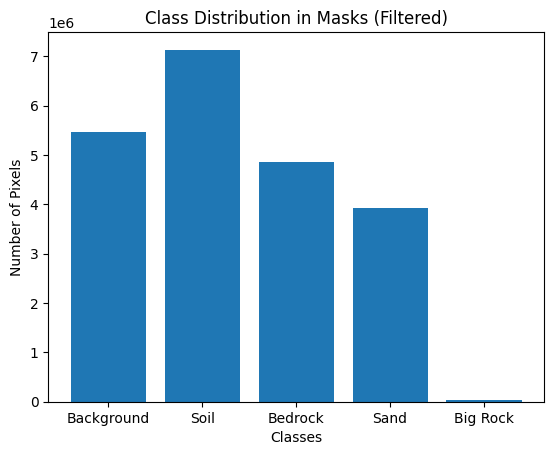

In [8]:
# Count the number of pixels per class
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))

# Print class distribution
print("Class Distribution in Masks (Filtered Dataset):")
for class_id, count in class_distribution.items():
    print(f"Class {class_id} ({class_labels[class_id]}): {count} pixels")

# Visualize class distribution
plt.bar(class_distribution.keys(), class_distribution.values(), tick_label=[class_labels[c] for c in class_distribution.keys()])
plt.title("Class Distribution in Masks (Filtered)")
plt.xlabel("Classes")
plt.ylabel("Number of Pixels")
plt.show()


In [9]:
total_pixels = np.prod(y_train_masks.shape)
class_percentages = {class_labels[c]: (count / total_pixels) * 100 for c, count in class_distribution.items()}
print("Class Percentages:")
for label, percent in class_percentages.items():
    print(f"{label}: {percent:.2f}%")


Class Percentages:
Background: 25.52%
Soil: 33.29%
Bedrock: 22.71%
Sand: 18.36%
Big Rock: 0.13%


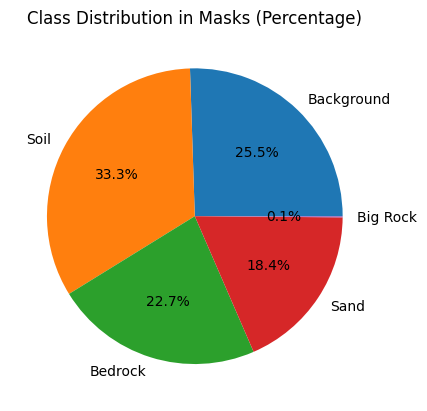

In [10]:
plt.pie(class_distribution.values(), labels=[class_labels[c] for c in class_distribution.keys()], autopct='%1.1f%%')
plt.title("Class Distribution in Masks (Percentage)")
plt.show()


In [11]:
# Identify empty masks
empty_mask_indices = [i for i, mask in enumerate(y_train_masks) if np.all(mask == 0)]
print(f"Number of empty masks: {len(empty_mask_indices)}")

# Check for masks with only one class
single_class_masks = [i for i, mask in enumerate(y_train_masks) if len(np.unique(mask)) == 1]
print(f"Number of masks with a single class: {len(single_class_masks)}")


Number of empty masks: 7
Number of masks with a single class: 425


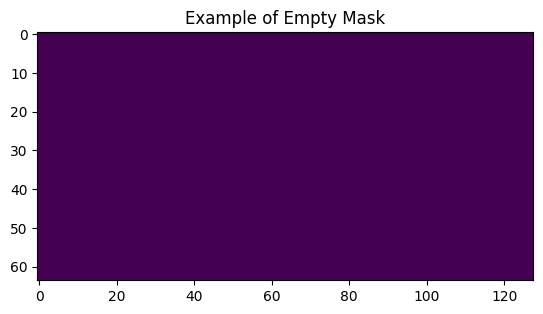

In [12]:

if empty_mask_indices:
    plt.imshow(y_train_masks[empty_mask_indices[0]], cmap="viridis")
    plt.title("Example of Empty Mask")
    plt.show()


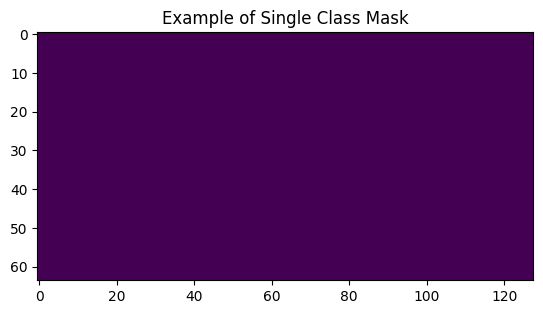

In [15]:

if single_class_masks:
    plt.imshow(y_train_masks[single_class_masks[20]], cmap="viridis")
    plt.title("Example of Single Class Mask")
    plt.show()


## Outliers

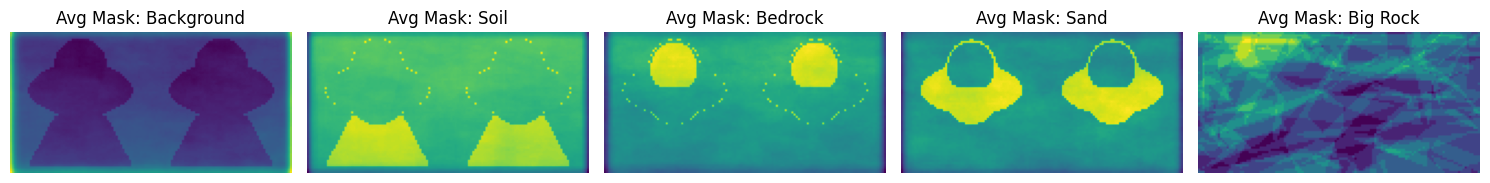

In [16]:
avg_masks = {}
for class_id in class_labels.keys():
    avg_masks[class_id] = np.mean((y_train_masks == class_id), axis=0)

# Plot average masks
fig, axes = plt.subplots(1, len(class_labels), figsize=(15, 4))
for class_id, ax in zip(class_labels.keys(), axes):
    ax.imshow(avg_masks[class_id], cmap="viridis")
    ax.set_title(f"Avg Mask: {class_labels[class_id]}")
    ax.axis("off")
plt.tight_layout()
plt.show()


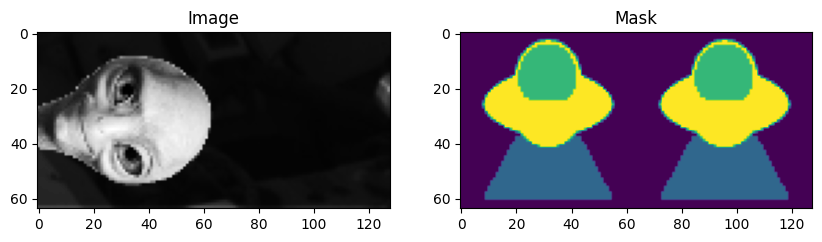

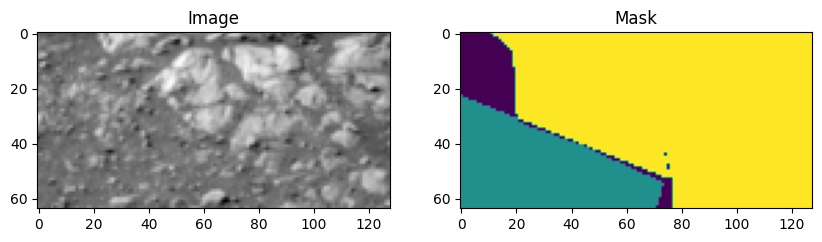

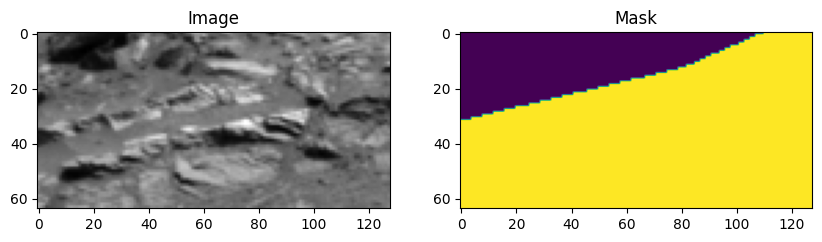

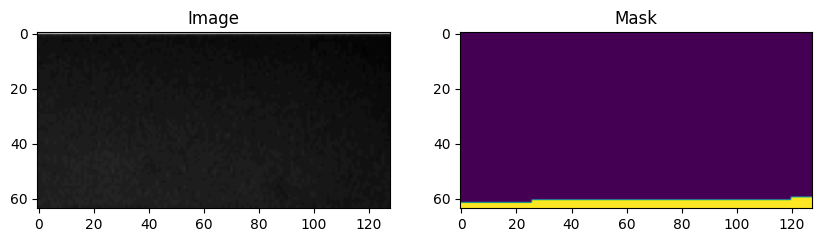

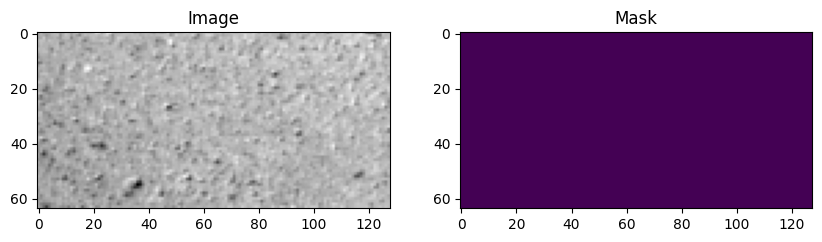

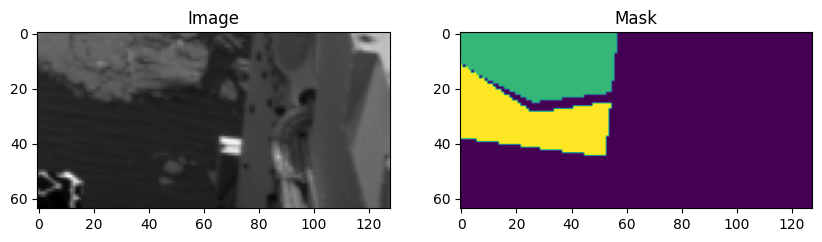

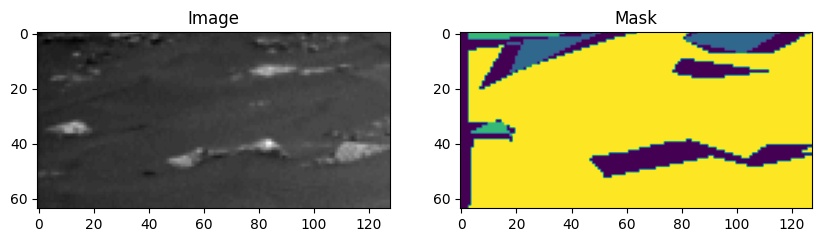

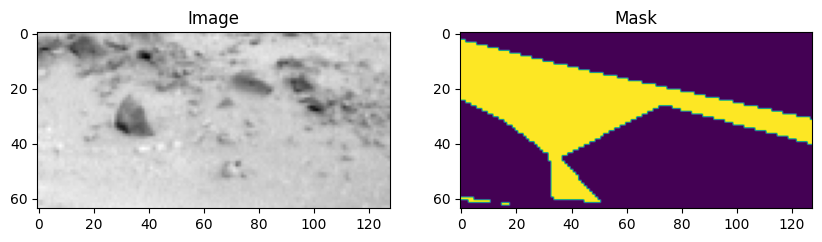

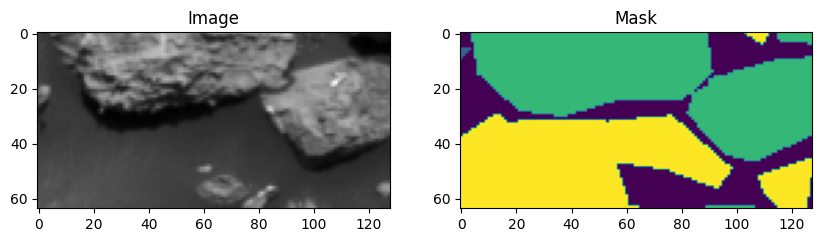

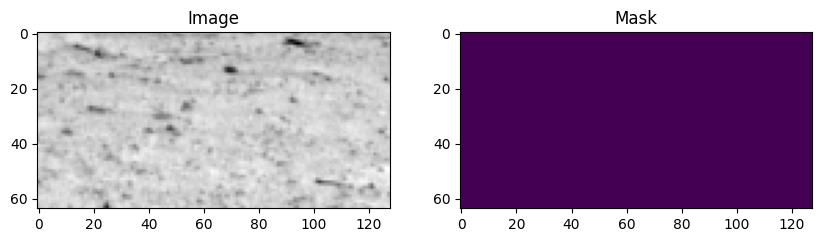

In [20]:
import random

# Randomly sample a few image-mask pairs
for _ in range(10):
    idx = random.randint(0, len(X_train_images) - 1)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(X_train_images[idx], cmap="gray")
    ax[0].set_title("Image")
    ax[1].imshow(y_train_masks[idx], cmap="viridis")
    ax[1].set_title("Mask")
    plt.show()


In [19]:
import numpy as np

# Calculate mean and standard deviation of pixel intensities for each image
image_features = np.array([[np.mean(img), np.std(img)] for img in X_train])

print(f"Feature shape: {image_features.shape}")


Feature shape: (2615, 2)


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


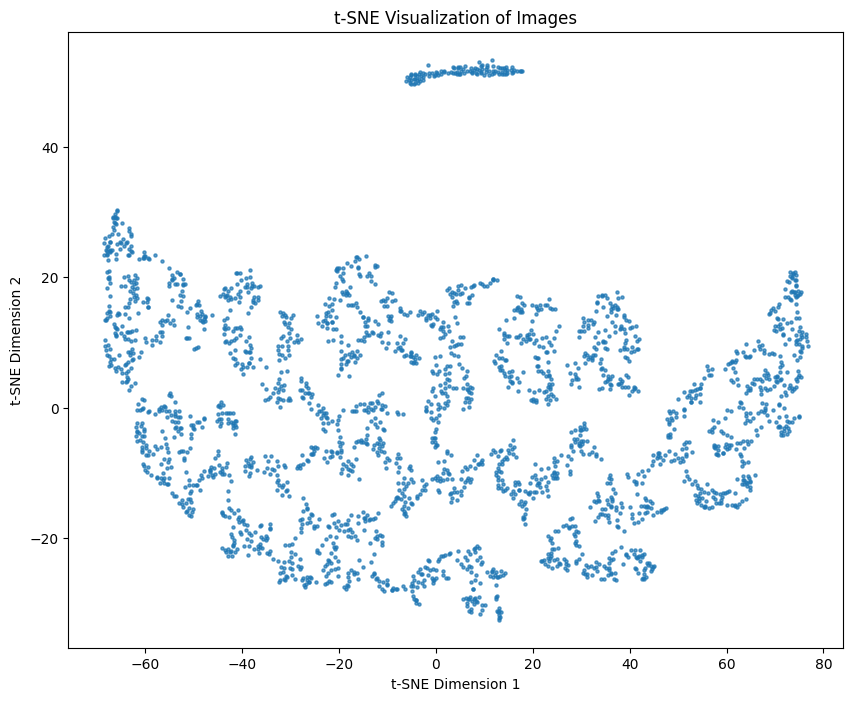

In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE to the features
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
image_tsne = tsne.fit_transform(image_features)

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
plt.scatter(image_tsne[:, 0], image_tsne[:, 1], s=5, alpha=0.7)
plt.title("t-SNE Visualization of Images")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


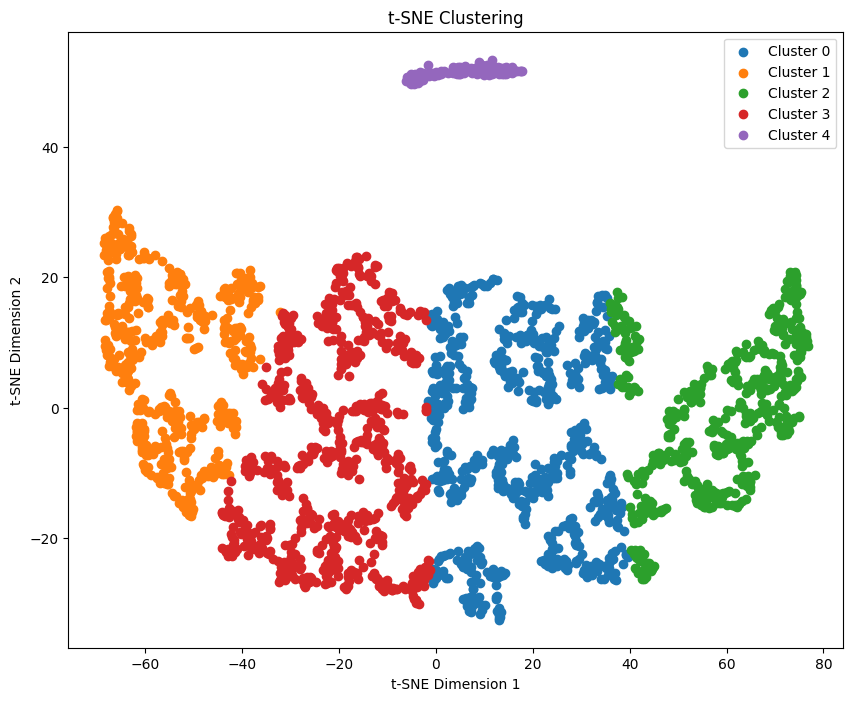

In [34]:
from sklearn.cluster import KMeans

# Apply k-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # Adjust the number of clusters as needed
labels = kmeans.fit_predict(image_tsne)

# Visualize clusters
plt.figure(figsize=(10, 8))
for cluster in np.unique(labels):
    plt.scatter(image_tsne[labels == cluster, 0], image_tsne[labels == cluster, 1], label=f"Cluster {cluster}")
plt.legend()
plt.title("t-SNE Clustering")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


Number of images in Cluster 4: 110


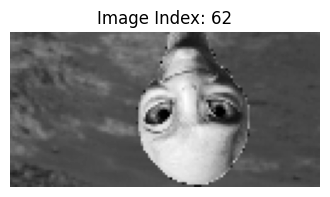

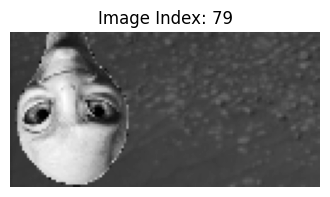

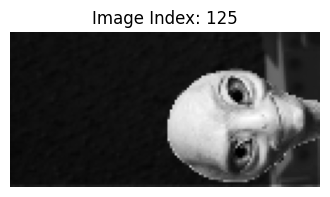

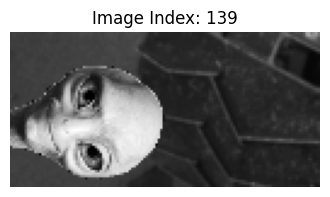

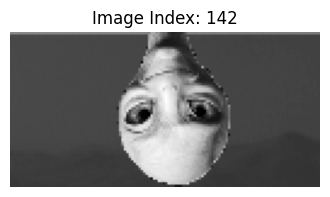

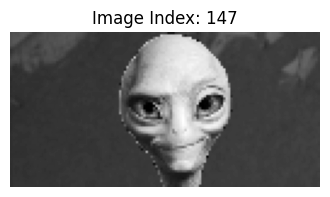

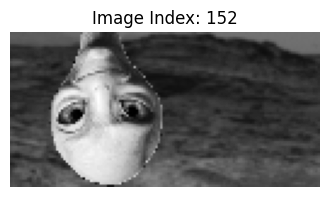

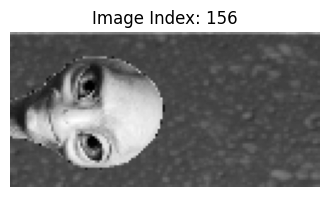

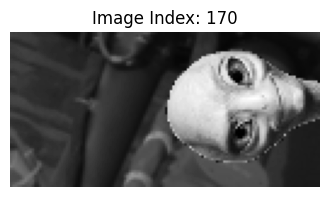

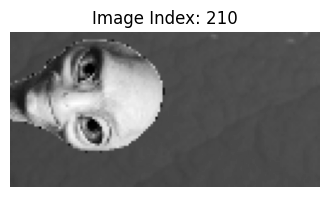

In [38]:
import matplotlib.pyplot as plt

# Assuming `labels` contains the cluster assignments from k-means or another clustering method
# Find indices of images in Cluster 4 (purple cluster)
cluster_4_indices = [i for i, label in enumerate(labels) if label == 4]

print(f"Number of images in Cluster 4: {len(cluster_4_indices)}")

# Visualize images in Cluster 4
for idx in cluster_4_indices[:10]:  # Show the first 10 images in the cluster
    plt.figure(figsize=(4, 4))
    plt.imshow(X_train[idx].squeeze(), cmap="gray")
    plt.title(f"Image Index: {idx}")
    plt.axis("off")
    plt.show()


In [41]:
import os
from PIL import Image

# Create a directory to save images
os.makedirs("cluster_4_images", exist_ok=True)

# Save images in Cluster 4
for idx in cluster_4_indices:
    image = X_train[idx].squeeze()
    Image.fromarray((image * 255).astype(np.uint8)).save(f"cluster_4_images/image_{idx}.png")


### Outliers removed

In [43]:
# Remove Cluster 4 indices from X_train_filtered and y_train_filtered
import numpy as np

# Find indices of images in Cluster 4 (purple cluster)
cluster_4_indices = [i for i, label in enumerate(labels) if label == 4]

print(f"Number of images in Cluster 4: {len(cluster_4_indices)}")

# Create filtered datasets by excluding Cluster 4 indices
X_train_filtered = np.delete(X_train, cluster_4_indices, axis=0)
y_train_filtered = np.delete(y_train, cluster_4_indices, axis=0)

print(f"Updated dataset size: {X_train_filtered.shape[0]} images, {y_train_filtered.shape[0]} masks")


Number of images in Cluster 4: 110
Updated dataset size: 2505 images, 2505 masks


In [44]:
X_train_images = np.array([x.reshape(64, 128) for x in X_train_filtered])
y_train_masks = np.array([y.reshape(64, 128) for y in y_train_filtered])

## Analysis without the outliers

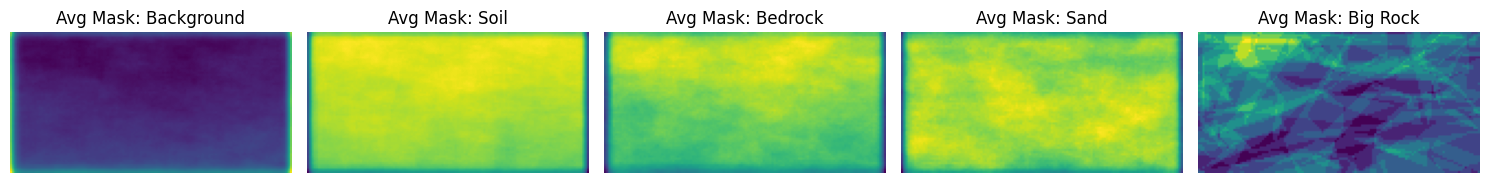

In [45]:
avg_masks = {}
for class_id in class_labels.keys():
    avg_masks[class_id] = np.mean((y_train_masks == class_id), axis=0)

# Plot average masks
fig, axes = plt.subplots(1, len(class_labels), figsize=(15, 4))
for class_id, ax in zip(class_labels.keys(), axes):
    ax.imshow(avg_masks[class_id], cmap="viridis")
    ax.set_title(f"Avg Mask: {class_labels[class_id]}")
    ax.axis("off")
plt.tight_layout()
plt.show()


CLASS IMBALANCE

Class Distribution in Masks (Filtered Dataset):
Class 0.0 (Background): 4988826 pixels
Class 1.0 (Soil): 6957538 pixels
Class 2.0 (Bedrock): 4776810 pixels
Class 3.0 (Sand): 3770823 pixels
Class 4.0 (Big Rock): 26963 pixels


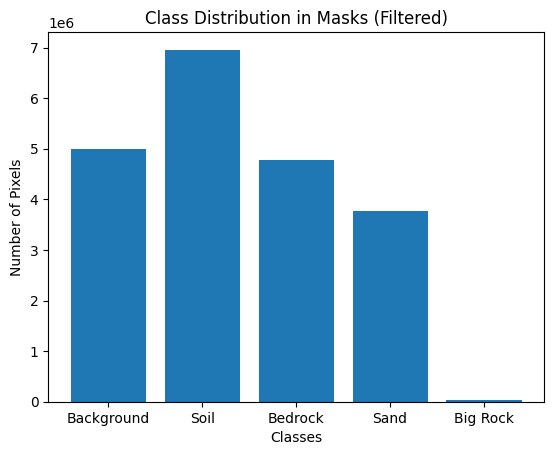

In [46]:
# Count the number of pixels per class
unique, counts = np.unique(y_train_filtered, return_counts=True)
class_distribution = dict(zip(unique, counts))

# Print class distribution
print("Class Distribution in Masks (Filtered Dataset):")
for class_id, count in class_distribution.items():
    print(f"Class {class_id} ({class_labels[class_id]}): {count} pixels")

# Visualize class distribution
plt.bar(class_distribution.keys(), class_distribution.values(), tick_label=[class_labels[c] for c in class_distribution.keys()])
plt.title("Class Distribution in Masks (Filtered)")
plt.xlabel("Classes")
plt.ylabel("Number of Pixels")
plt.show()


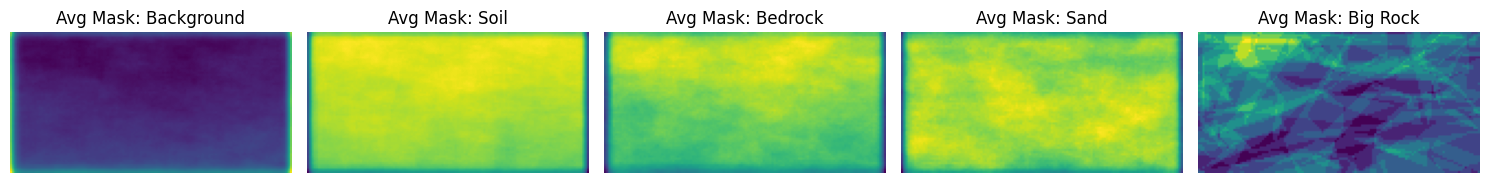

In [47]:
# Compute average mask for each class
avg_masks = {}
for class_id in class_labels.keys():
    avg_masks[class_id] = np.mean((y_train_filtered == class_id), axis=0)

# Visualize average masks
fig, axes = plt.subplots(1, len(class_labels), figsize=(15, 4))
for class_id, ax in zip(class_labels.keys(), axes):
    ax.imshow(avg_masks[class_id], cmap="viridis")
    ax.set_title(f"Avg Mask: {class_labels[class_id]}")
    ax.axis("off")
plt.tight_layout()
plt.show()


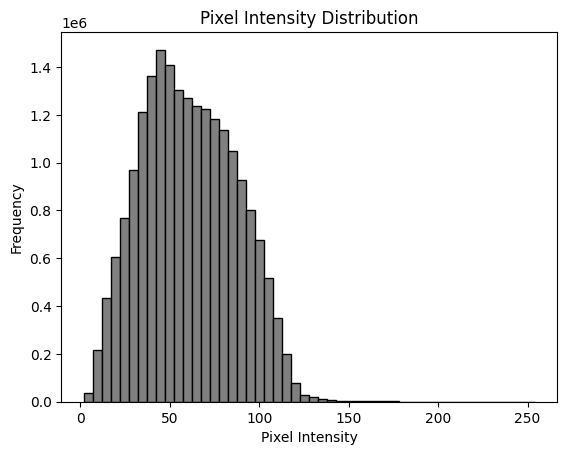

In [48]:
# Flatten all images to a 1D array
pixel_values = X_train_filtered.flatten()

# Plot histogram of pixel intensities
plt.hist(pixel_values, bins=50, color="gray", edgecolor="black")
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()


In [49]:
# Identify indices of images containing Big Rock (class 4)
big_rock_indices = [i for i, mask in enumerate(y_train_filtered) if 4 in mask]

# Extract images and masks containing Big Rock
X_big_rock = X_train_filtered[big_rock_indices]
y_big_rock = y_train_filtered[big_rock_indices]

print(f"Number of Big Rock images: {len(X_big_rock)}")


Number of Big Rock images: 63


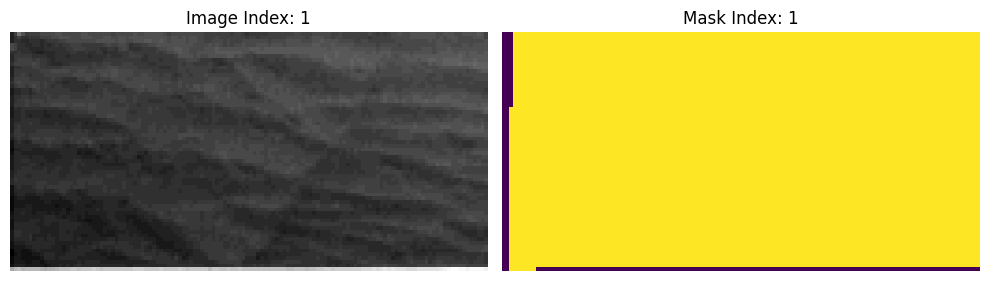

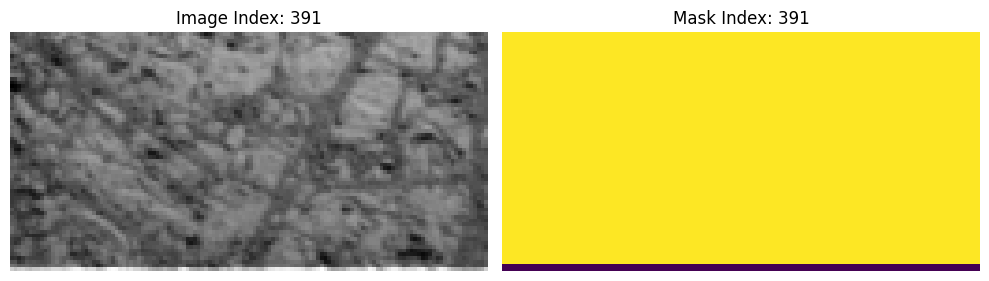

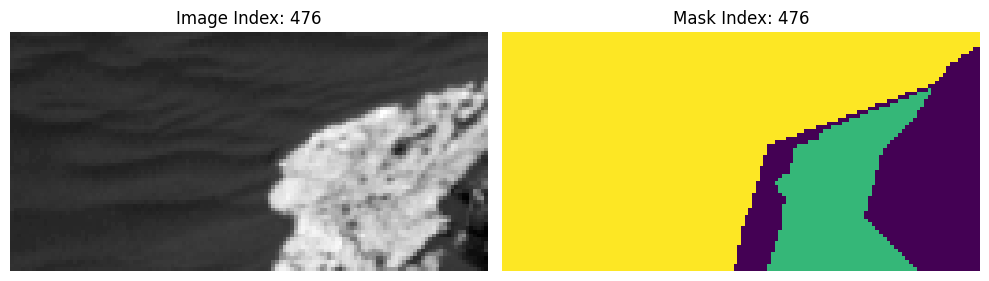

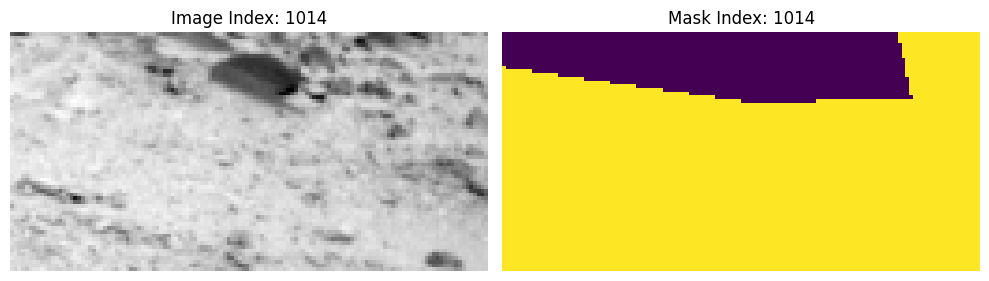

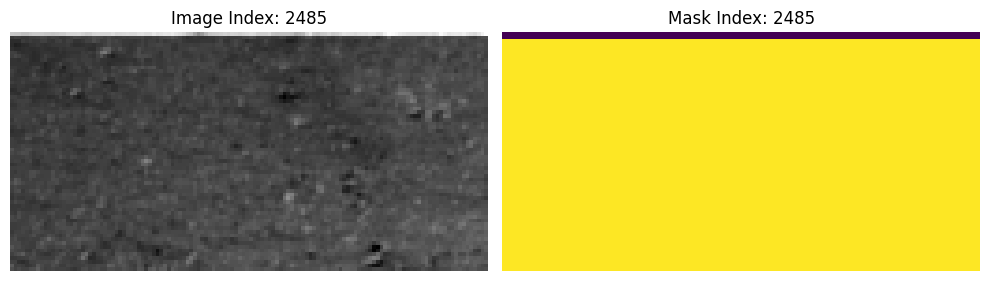

In [50]:
import random

# Visualize random image-mask pairs
for _ in range(5):
    idx = random.randint(0, len(X_train_filtered) - 1)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Display input image
    ax[0].imshow(X_train_filtered[idx], cmap="gray")
    ax[0].set_title(f"Image Index: {idx}")
    ax[0].axis("off")

    # Display corresponding mask
    ax[1].imshow(y_train_filtered[idx], cmap="viridis")
    ax[1].set_title(f"Mask Index: {idx}")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


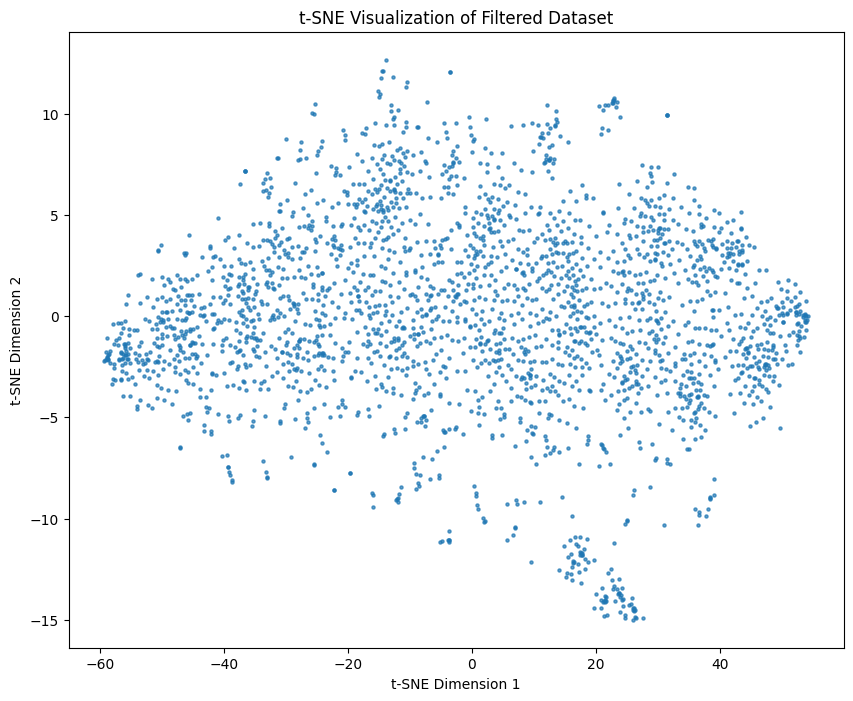

In [51]:
from sklearn.manifold import TSNE

# Flatten images for t-SNE
X_flattened = X_train_filtered.reshape(X_train_filtered.shape[0], -1)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_flattened)

# Plot t-SNE results
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=5, alpha=0.7)
plt.title("t-SNE Visualization of Filtered Dataset")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


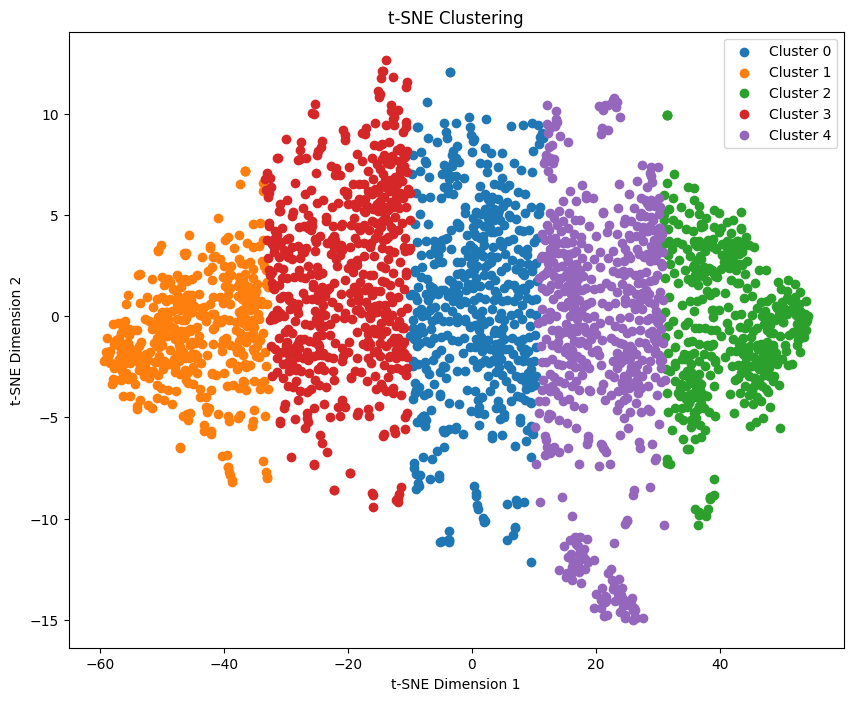

In [52]:
from sklearn.cluster import KMeans

# Apply k-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # Adjust the number of clusters as needed
labels = kmeans.fit_predict(X_tsne)

# Visualize clusters
plt.figure(figsize=(10, 8))
for cluster in np.unique(labels):
    plt.scatter(X_tsne[labels == cluster, 0], X_tsne[labels == cluster, 1], label=f"Cluster {cluster}")
plt.legend()
plt.title("t-SNE Clustering")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


## 🛠️ Train and Save the Model

In [ ]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

In [ ]:
inputs = tfkl.Input(shape=input_shape)
x = tfkl.Conv2D(filters=num_classes, kernel_size=(1, 1), activation="softmax")(inputs)
model = tfk.Model(inputs=inputs, outputs=x, name="minimal_working_net")

# Define the MeanIoU ignoring the background class
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=[mean_iou])

model.summary()

In [ ]:
history = model.fit(X_train, y_train, epochs=1)

In [ ]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [ ]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [ ]:
model = tfk.models.load_model(model_filename)
print(f"Model loaded from {model_filename}")

In [ ]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```